In [1]:
import tensorflow as tf 
tf.random.set_seed(0)

#Confirmando a gpu
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
import numpy as np

#Merge the training and testing sets
dataset = np.concatenate((X_train, X_test), axis=0)
#Normalize the images from [0, 255] to [0, 1]
dataset = np.expand_dims(dataset, axis=-1).astype('float32') / 255

In [4]:
BATCH_SIZE = 64

dataset = np.reshape(dataset, (-1, 28, 28, 1))
#Create a tensorflow dataset object
dataset = tf.data.Dataset.from_tensor_slices(dataset)
#Set the batch size otherwise it reads one image at a time
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

NOISE_DIM= 150

#design a generartor model with upsampling layers
# in GAN's pratices, usually the generator has leaky relu activation function
generator = keras.models.Sequential([
    keras.Input(shape=(NOISE_DIM,)),
    layers.Dense(7*7*256),
    layers.Reshape((7, 7, 256)),
    layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')
])

generator.summary()

c:\Users\vish8\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,894,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,553 (8.63 MB)

 Trainable params: 2,263,553 (8.63 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#Design a discriminator model with downsampling layers
discriminator = keras.models.Sequential([
    keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(256, kernel_size=3, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
discriminator.summary()

c:\Users\vish8\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,761 (1.43 MB)

 Trainable params: 373,761 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# set different learning rates for the generator and the discriminator
# we want to maintain the game balance until we arrive at the nash-equilibria
# if the discriminator gets very strong or very weak the adversarial game fails
# higher learning rates impact the stability of the adversarial game severely
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)

# binary classifier (real or fake)
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

# accuracy metric
gAccMetric = tf.keras.metrics.BinaryAccuracy()
dAccMetric = tf.keras.metrics.BinaryAccuracy()

In [23]:
# observe the annotation allows for efficient native tensoflow compiling
@tf.function
def trainDStep(data):
  # the batch is (32,28,28,1), so extract 32 value
  batchSize = tf.shape(data)[0]
  # create a noise vector as generator input sampled from Gaussian Random Normal
  # As an exercise try sampling from a uniform distribution and observe the difference
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))

  # concatenate the real and fake labels
  y_true = tf.concat(
    [
      # the original data is real, labeled with 1
      tf.ones(batchSize, 1),
      # the forged data is fake, labeled with 0
      tf.zeros(batchSize, 1)
    ],
    axis=0
  )

  # record the calculated gradients
  with tf.GradientTape() as tape:
    # generate forged samples
    fake = generator(noise)
    # concatenate real data and forged data
    x = tf.concat([data, fake], axis=0)
    # see if the discriminator detects them
    y_pred = discriminator(x)
    # calculate the loss
    discriminatorLoss = lossFn(y_true, y_pred)

  # apply the backward path and update weights
  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

  # report accuracy
  dAccMetric.update_state(y_true, y_pred)

  # return the loss for visualization
  return {
      "discriminator_loss": discriminatorLoss,
      "discriminator_accuracy": dAccMetric.result()
  }

In [24]:
@tf.function
def trainGStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))
  # when training the generator, we want it to maximize the probability that its
  # output is classified as real, remember the min-max game
  y_true = tf.ones(batchSize, 1)

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generatorLoss = lossFn(y_true, y_pred)

  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

  gAccMetric.update_state(y_true, y_pred)

  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
  }

In [25]:
from matplotlib import pyplot as plt
def plotImages(model):
    images = model(np.random.normal(size=(10, NOISE_DIM)))
    plt.figure(figsize=(15, 15))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

E:0, Loss G:2.8801, Loss D:0.1233, Acc G:%0.06, Acc D:%92.71


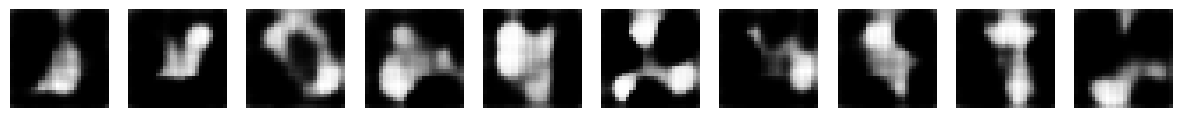

E:1, Loss G:2.3350, Loss D:0.1537, Acc G:%0.19, Acc D:%97.48
E:2, Loss G:2.3434, Loss D:0.1891, Acc G:%0.48, Acc D:%96.74


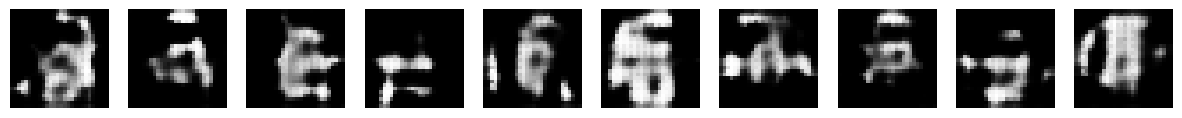

E:3, Loss G:2.1724, Loss D:0.2537, Acc G:%1.38, Acc D:%95.56
E:4, Loss G:2.0065, Loss D:0.2576, Acc G:%2.25, Acc D:%94.53


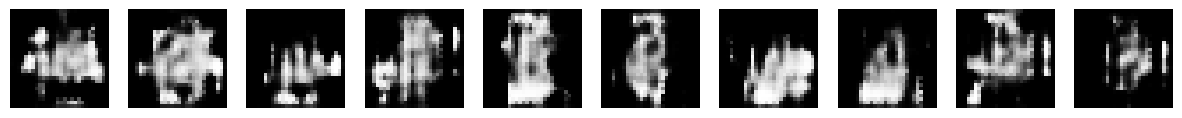

E:5, Loss G:1.8861, Loss D:0.2820, Acc G:%2.74, Acc D:%94.00
E:6, Loss G:1.9564, Loss D:0.2677, Acc G:%3.31, Acc D:%93.47


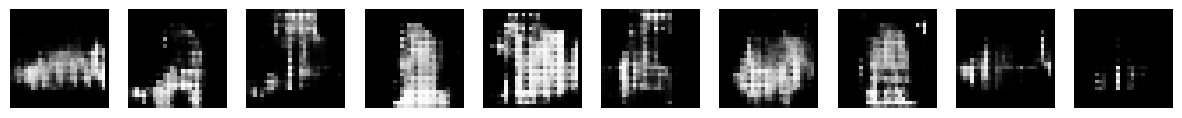

E:7, Loss G:1.7248, Loss D:0.3375, Acc G:%3.68, Acc D:%92.99
E:8, Loss G:1.7131, Loss D:0.3413, Acc G:%4.39, Acc D:%92.20


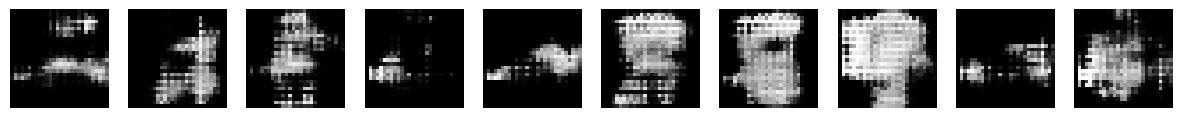

E:9, Loss G:1.7505, Loss D:0.3493, Acc G:%4.85, Acc D:%91.68
E:10, Loss G:1.6811, Loss D:0.3641, Acc G:%5.38, Acc D:%91.12


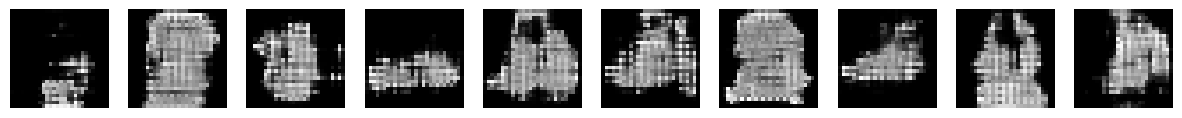

E:11, Loss G:1.4761, Loss D:0.4334, Acc G:%6.00, Acc D:%90.45
E:12, Loss G:1.4187, Loss D:0.4400, Acc G:%6.67, Acc D:%89.63


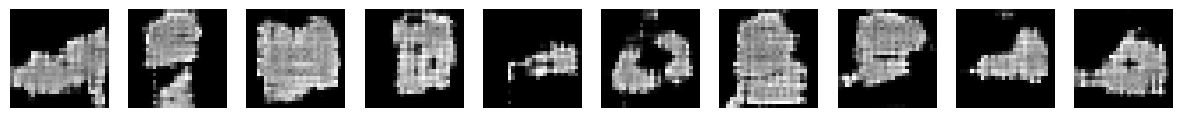

E:13, Loss G:1.3669, Loss D:0.4421, Acc G:%7.25, Acc D:%88.96
E:14, Loss G:1.3688, Loss D:0.4398, Acc G:%7.77, Acc D:%88.38


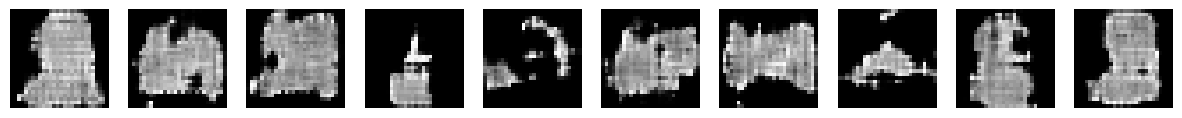

E:15, Loss G:1.3898, Loss D:0.4308, Acc G:%8.23, Acc D:%87.90
E:16, Loss G:1.4132, Loss D:0.4307, Acc G:%8.61, Acc D:%87.51


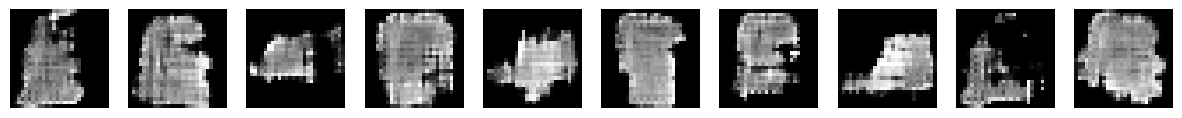

E:17, Loss G:1.3891, Loss D:0.4460, Acc G:%8.97, Acc D:%87.12
E:18, Loss G:1.3397, Loss D:0.4846, Acc G:%9.38, Acc D:%86.66


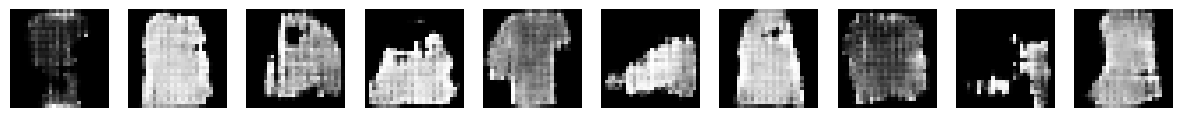

E:19, Loss G:1.2942, Loss D:0.5110, Acc G:%9.84, Acc D:%86.12
E:20, Loss G:1.2645, Loss D:0.5157, Acc G:%10.29, Acc D:%85.59


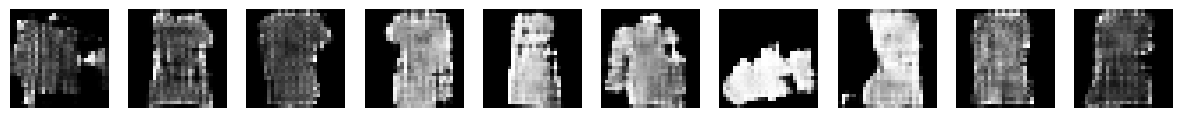

E:21, Loss G:1.2422, Loss D:0.5145, Acc G:%10.67, Acc D:%85.09
E:22, Loss G:1.2203, Loss D:0.5123, Acc G:%10.95, Acc D:%84.66


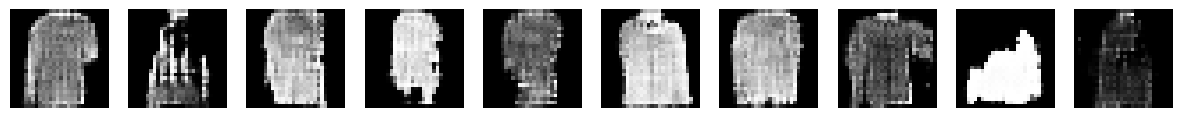

E:23, Loss G:1.2096, Loss D:0.5117, Acc G:%11.19, Acc D:%84.25
E:24, Loss G:1.1975, Loss D:0.5090, Acc G:%11.36, Acc D:%83.89


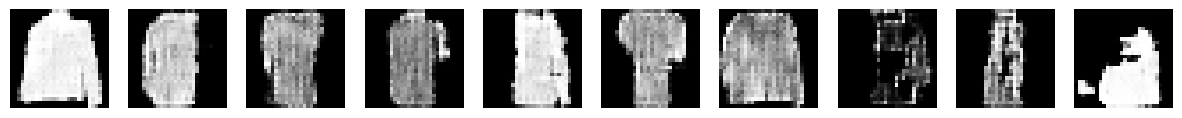

E:25, Loss G:1.1778, Loss D:0.5114, Acc G:%11.49, Acc D:%83.54
E:26, Loss G:1.1650, Loss D:0.5111, Acc G:%11.59, Acc D:%83.22


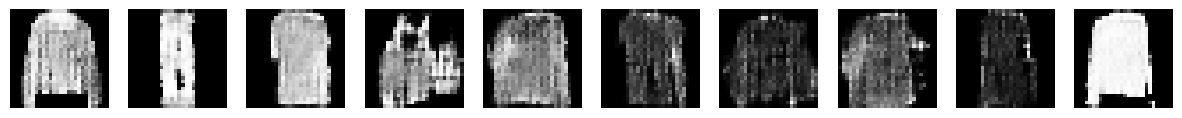

E:27, Loss G:1.1540, Loss D:0.5114, Acc G:%11.65, Acc D:%82.90
E:28, Loss G:1.1434, Loss D:0.5157, Acc G:%11.70, Acc D:%82.60


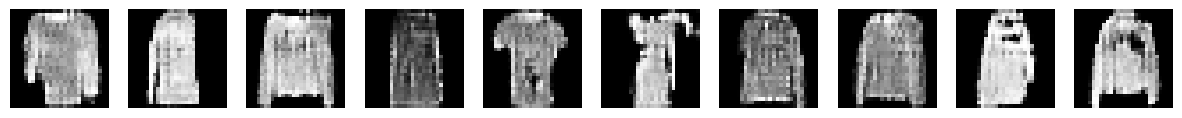

E:29, Loss G:1.1368, Loss D:0.5137, Acc G:%11.73, Acc D:%82.31


In [26]:
# we don't use the model.fit method any more since the original GANs paper trained
# the discriminator for 5 steps and then the generator for 1 step
# the value 5 is subject to fine-tuning depending on the model design and the dataset
# in this example, training both for 1 step
# note: the adversarial game may diverge after it has converged
# that's why it is customary to visualize the generated images every few epochs
# some even put the images together into a video
for epoch in range(30):

  # accumulate the loss to calculate the average at the end of the epoch
  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  cnt = 0

  # loop the dataset one batch at a time
  for batch in dataset:

    # train the discriminator
    # remember you could repeat these 2 lines of code for K times
    dLoss = trainDStep(batch)
    dLossSum += dLoss['discriminator_loss']
    dAccSum += dLoss['discriminator_accuracy']

    # train the generator
    gLoss = trainGStep(batch)
    gLossSum += gLoss['generator_loss']
    gAccSum += gLoss['generator_accuracy']

    # increment the counter
    cnt += 1

  # log the performance
  print("E:{}, Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
      epoch,
      gLossSum/cnt,
      dLossSum/cnt,
      100 * gAccSum/cnt,
      100 * dAccSum/cnt
  ))
    
  if epoch % 2 == 0:
    plotImages(generator)